In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import math
from tensorflow.keras.applications import InceptionResNetV2
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, MaxPooling2D, Dense, Flatten, Dropout, LeakyReLU, Conv2D, BatchNormalization

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
EPOCHS = 30
NUM_CLASSES = 3

In [5]:
train_chicken_pox = os.path.join (r"data/training/ChickenPox")
train_measles = os.path.join (r"data/training/Measles")
train_monkey_pox = os.path.join (r"data/training/MonkeyPox")

In [6]:
val_chicken_pox = os.path.join (r"data/validation/ChickenPox")
val_measles = os.path.join (r"data/validation/Measles")
val_monkey_pox = os.path.join (r"data/validation/MonkeyPox")

## Classified Images

## ChickenPox Sample Images

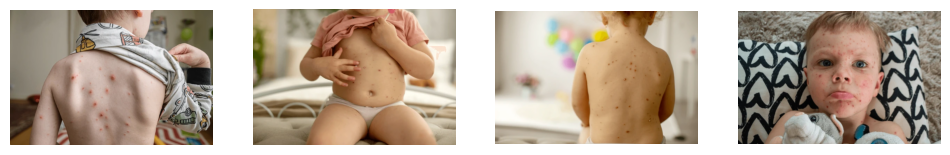

In [7]:
import matplotlib.image as mpimg
chicken_pox_img = [os.path.join(train_chicken_pox, file)
              for file in os.listdir(train_chicken_pox)[:4]]
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(chicken_pox_img):
    sp = plt.subplot(1, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

## Measles Sample Images

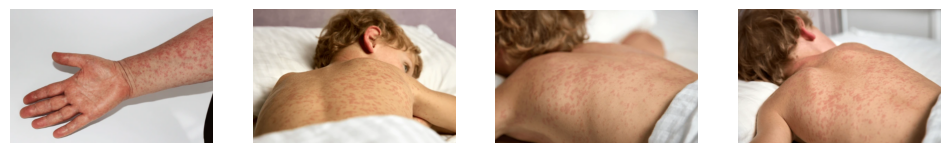

In [8]:
measles_img = [os.path.join(train_measles, file)
              for file in os.listdir(train_measles)[:4]]
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(measles_img):
    sp = plt.subplot(1, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

## Monkeypox Sample Images

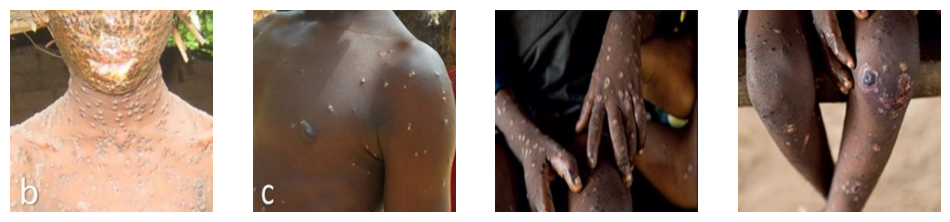

In [9]:
monkey_pox_img = [os.path.join(train_monkey_pox, file)
              for file in os.listdir(train_monkey_pox)[6:10]]
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(monkey_pox_img):
    sp = plt.subplot(1, 4, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

## Custom CNN

In [10]:
datagen_c = ImageDataGenerator(         
    zoom_range=0.5, 
    rotation_range=50,          
    horizontal_flip=True,       
    fill_mode='nearest'        
)

In [11]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [12]:
#==================Training dataset============================
train_c = datagen_c.flow_from_directory(
    directory=r"data/training", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)
#==================Testing dataset============================
test_c = datagen_c.flow_from_directory(
    directory="data/test", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)

Found 480 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [7]:
label_map = {'ChickenPox': 0, 'Measles': 1, 'MonkeyPox': 2}

In [8]:
def getType(id):
    return list(label_map.keys())[list(label_map.values()).index(id)]

# predict new images
def predictImagesClass(model, val_data, image_width, image_height):
    val_df = pd.DataFrame(columns=['Image No.', 'Predicted Image Class'])
    cnn_img = [os.path.join(val_data, file) 
                      for file in os.listdir(val_data)[:]]
    for i, img_path in enumerate(cnn_img):
        img = image.load_img(img_path, target_size=(image_width, image_height))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_batch)
        val_df.loc[len(val_df.index)] = [(i+1), getType(np.argmax(prediction))]
    return val_df

In [15]:
model = Sequential()

In [16]:
# Adding input layer
model.add(Input(shape=(256, 256, 3)))

# Adding second convolutional layer 
model.add(Conv2D(32, (3, 3), strides=1))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Adding third convolutional layer
model.add(Conv2D(64, (3, 3), strides=1))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Adding forth convolutional layer 
model.add(Conv2D(128, (3, 3), strides=1, padding='same'))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(negative_slope=0.01))

model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [17]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    31,490,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,585,219 (120.49 MB)

 Trainable params: 31,584,771 (120.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
#=========================Early Stop Condition========================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
hist = model.fit(
    train_c,
    epochs = EPOCHS,
    verbose = 1, 
    validation_data = test_c,
    callbacks=[early_stopping]
)

Epoch 1/30


I0000 00:00:1727050865.615903   32203 service.cc:146] XLA service 0x2b5f00004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727050865.615967   32203 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
E0000 00:00:1727050867.952041   32203 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727050868.292897   32203 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 1/30 ━━━━━━━━━━━━━━━━━━━━ 6:00 12s/step - accuracy: 0.3125 - loss: 2.1346

I0000 00:00:1727050873.564964   32203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.4296 - loss: 3.6849 - val_accuracy: 0.4141 - val_loss: 15.9773
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.5068 - loss: 4.4954 - val_accuracy: 0.4545 - val_loss: 6.9834
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.5103 - loss: 3.3750 - val_accuracy: 0.4747 - val_loss: 3.6215
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.6190 - loss: 2.5006 - val_accuracy: 0.3737 - val_loss: 2.0635
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - accuracy: 0.5855 - loss: 2.2281 - val_accuracy: 0.3232 - val_loss: 1.9970
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.6167 - loss: 1.6300 - val_accuracy: 0.3636 - val_loss: 1.8609
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.6400 - loss: 1.4756 - val_accuracy: 0.5657 - val_loss: 2.3977
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.6049 - loss: 1.5619 - val_accuracy: 0.35

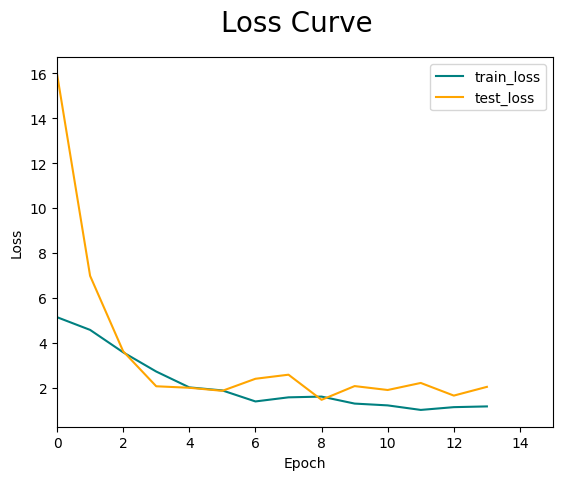

In [21]:
#==========================Loss Function===========================
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'test_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,15)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

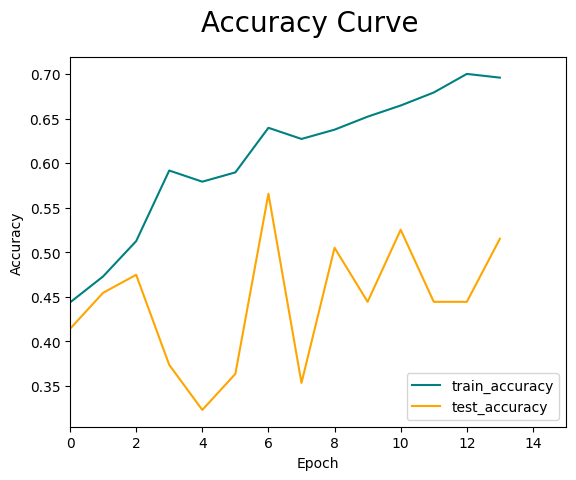

In [22]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'test_accuracy')
fig.suptitle('Accuracy Curve', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [23]:
chickenpox_val_df_cnn = predictImagesClass(model, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)    
display(chickenpox_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,Image No.,Predicted Image Class
0,1,Measles
1,2,Measles
2,3,Measles
3,4,MonkeyPox
4,5,ChickenPox
5,6,ChickenPox
6,7,ChickenPox
7,8,ChickenPox


In [24]:
measles_val_df_cnn = predictImagesClass(model, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)  
display(measles_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Image No.,Predicted Image Class
0,1,MonkeyPox
1,2,ChickenPox
2,3,MonkeyPox
3,4,Measles
4,5,Measles
5,6,MonkeyPox
6,7,ChickenPox
7,8,MonkeyPox


In [26]:
monkey_pox_df_cnn = predictImagesClass(model, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT)  
display(monkey_pox_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


,Image No.,Predicted Image Class
0,1,Measles
1,2,MonkeyPox
2,3,MonkeyPox
3,4,MonkeyPox
4,5,MonkeyPox
5,6,Measles
6,7,MonkeyPox
7,8,MonkeyPox


# Inception-ResNet V2

In [9]:
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299

In [10]:
#================================Augmentation of the image=============================
datagen = ImageDataGenerator(horizontal_flip=True,zoom_range=0.5,
                            fill_mode='nearest')

In [11]:
#==================Training dataset============================
train = datagen.flow_from_directory(
    directory=r"data/training", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)
#==================Testing dataset============================
test = datagen.flow_from_directory(
    directory="data/test", 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    class_mode='sparse',
    seed = 42
)

Found 480 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [12]:
model1 = InceptionResNetV2(weights='imagenet')

In [13]:
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
hist2 = model1.fit(
    train,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = test,
    callbacks=[early_stopping]
)

Epoch 1/30


I0000 00:00:1727052325.954694   35147 service.cc:146] XLA service 0x2b5330001610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727052325.954781   35147 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
E0000 00:00:1727052353.070463   35147 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727052353.411159   35147 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1727052399.573271   35147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 167s 984ms/step - accuracy: 0.1840 - loss: 5.5323 - val_accuracy: 0.6970 - val_loss: 1.3981
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - accuracy: 0.8626 - loss: 0.8100 - val_accuracy: 0.7980 - val_loss: 1.0490
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.9198 - loss: 0.3168 - val_accuracy: 0.8283 - val_loss: 0.9118
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step - accuracy: 0.9193 - loss: 0.2669 - val_accuracy: 0.8485 - val_loss: 0.6128
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.9690 - loss: 0.0796 - val_accuracy: 0.8586 - val_loss: 0.6126
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.9759 - loss: 0.0953 - val_accuracy: 0.8182 - val_loss: 0.6695
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.9685 - loss: 0.1027 - val_accuracy: 0.8889 - val_loss: 0.4236
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.9575 - loss: 0.1065 - val_accuracy: 0.89

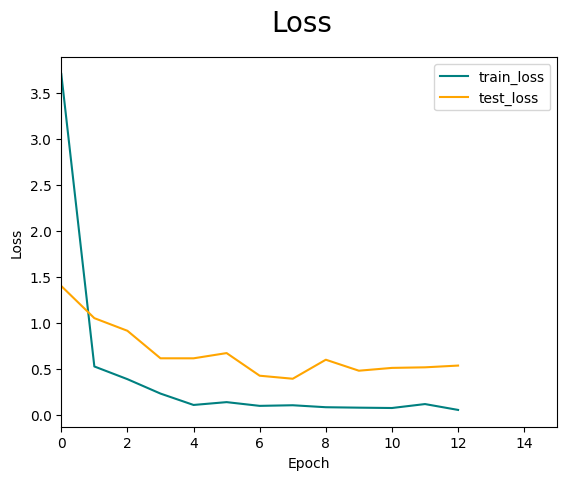

In [16]:
### ==========================Loss Function===========================
fig = plt.figure()
plt.plot(hist2.history['loss'], color = 'teal', label = 'train_loss')
plt.plot(hist2.history['val_loss'], color = 'orange', label = 'test_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,15)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

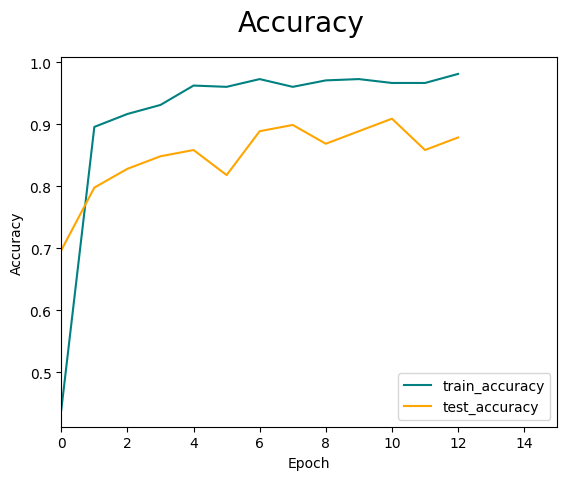

In [17]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color = 'teal', label = 'train_accuracy')
plt.plot(hist2.history['val_accuracy'], color = 'orange', label = 'test_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
chickenpox_val_df_cnn = predictImagesClass(model1, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)  
display(chickenpox_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


,Image No.,Predicted Image Class
0,1,ChickenPox
1,2,ChickenPox
2,3,ChickenPox
3,4,ChickenPox
4,5,ChickenPox
5,6,ChickenPox
6,7,ChickenPox
7,8,ChickenPox


In [20]:
measles_val_df_cnn = predictImagesClass(model1, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)    
display(measles_val_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


,Image No.,Predicted Image Class
0,1,Measles
1,2,Measles
2,3,Measles
3,4,ChickenPox
4,5,MonkeyPox
5,6,Measles
6,7,Measles
7,8,Measles


In [21]:
monkey_pox_df_cnn = predictImagesClass(model1, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT)  
display(monkey_pox_df_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


,Image No.,Predicted Image Class
0,1,MonkeyPox
1,2,MonkeyPox
2,3,MonkeyPox
3,4,ChickenPox
4,5,MonkeyPox
5,6,MonkeyPox
6,7,ChickenPox
7,8,MonkeyPox
